In [1]:
import xml.sax
import copy
import networkx

#highway_cat = 'motorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link'

def download_osm(left,bottom,right,top,highway_cat):
    """
    Downloads OSM street (only highway-tagged) Data using a BBOX, 
    plus a specification of highway tag values to use
    Parameters
    ----------
    left,bottom,right,top : BBOX of left,bottom,right,top coordinates in WGS84
    highway_cat : highway tag values to use, separated by pipes (|), for instance 'motorway|trunk|primary'
    Returns
    ----------
    stream object with osm xml data
    """

    #Return a filehandle to the downloaded data."""
    from urllib import urlopen
    #fp = urlopen( "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f"%(left,bottom,right,top) )
    #fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
    print "trying to download osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat
    try:    
        print "downloading osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat
        fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=%s][bbox=%f,%f,%f,%f]"%(highway_cat,left,bottom,right,top) )
        #slooww only ways,and in ways only "highways" (i.e. roads)
        #fp = urlopen( "http://open.mapquestapi.com/xapi/api/0.6/way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
        return fp
    except:
        print "osm data download unsuccessful"

def read_osm(filename_or_stream, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> plot([G.node[n]['data'].lat for n in G], [G.node[n]['data'].lon for n in G], ',')
    """
    osm = OSM(filename_or_stream)
    G = networkx.DiGraph()
 
    for w in osm.ways.itervalues():
        if only_roads and 'highway' not in w.tags:
            continue
        G.add_path(w.nds, id=w.id, highway = w.tags['highway'], street= w.tags['name'])#{str(k): type(v) for k,v in w.tags.items()})
        
        if 'oneway' not in w.tags and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id= '-' + str(w.id), highway = w.tags['highway'], street= w.tags['name'])

        elif w.tags['oneway'] != 'yes' and w.tags['oneway'] != '-1' and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id=w.id, highway = w.tags['highway'], street= w.tags['name'])

        
    for n_id in G.nodes_iter():
        n = osm.nodes[n_id]
        G.node[n_id] = dict(lon=n.lon,lat=n.lat)
    return G
        
    
class Node:
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}
        
class Way:
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}
        
    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    #print "slice at %s"%ar[i]
                    left = ar[:i+1]
                    right = ar[i:]
                    
                    rightsliced = slice_array(right, dividers)
                    
                    return [left]+rightsliced
            return [ar]
            


        slices = slice_array(self.nds, dividers)
        
        # create a way object for each node-array slice
        ret = []
        i=0
        for slice in slices:
            littleway = copy.copy( self )
            littleway.id += "-%d"%i
            littleway.nds = slice
            ret.append( littleway )
            i += 1
            
        return ret
        
        
 
class OSM:
    def __init__(self, filename_or_stream):
        """ File can be either a filename or stream/file object."""
        nodes = {}
        ways = {}
        
        superself = self
        
        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self,loc):
                pass
            
            @classmethod
            def startDocument(self):
                pass
                
            @classmethod
            def endDocument(self):
                pass
                
            @classmethod
            def startElement(self, name, attrs):
                if name=='node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name=='way':
                    self.currElem = Way(attrs['id'], superself)
                elif name=='tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name=='nd':
                    self.currElem.nds.append( attrs['ref'] )
                
            @classmethod
            def endElement(self,name):
                if name=='node':
                    nodes[self.currElem.id] = self.currElem
                elif name=='way':
                    ways[self.currElem.id] = self.currElem
                
            @classmethod
            def characters(self, chars):
                pass
 
        xml.sax.parse(filename_or_stream, OSMHandler)
        
        self.nodes = nodes
        self.ways = ways
        #"""   
        #count times each node is used
        node_histogram = dict.fromkeys( self.nodes.keys(), 0 )
        for way in self.ways.values():
            if len(way.nds) < 2:       #if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1
        
        #use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.iteritems():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways
        #"""

SyntaxError: invalid syntax (<ipython-input-1-3ebc39cf01cc>, line 24)

In [2]:
"""
Read graphs in Open Street Maps osm format
Based on osm.py from brianw's osmgeocode
http://github.com/brianw/osmgeocode, which is based on osm.py from
comes from Graphserver:
http://github.com/bmander/graphserver/tree/master and is copyright (c)
2007, Brandon Martin-Anderson under the BSD License
"""

import xml.sax
import copy
import networkx

#highway_cat = 'motorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link'

def download_osm(left,bottom,right,top,highway_cat):
    """
    Downloads OSM street (only highway-tagged) Data using a BBOX, 
    plus a specification of highway tag values to use
    Parameters
    ----------
    left,bottom,right,top : BBOX of left,bottom,right,top coordinates in WGS84
    highway_cat : highway tag values to use, separated by pipes (|), for instance 'motorway|trunk|primary'
    Returns
    ----------
    stream object with osm xml data
    """

    #Return a filehandle to the downloaded data."""
    from urllib import urlopen
    #fp = urlopen( "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f"%(left,bottom,right,top) )
    #fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
    print "trying to download osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat
    try:    
        print "downloading osm data from "+str(left),str(bottom),str(right),str(top)+" with highways of categories"+highway_cat
        fp = urlopen( "http://www.overpass-api.de/api/xapi?way[highway=%s][bbox=%f,%f,%f,%f]"%(highway_cat,left,bottom,right,top) )
        #slooww only ways,and in ways only "highways" (i.e. roads)
        #fp = urlopen( "http://open.mapquestapi.com/xapi/api/0.6/way[highway=*][bbox=%f,%f,%f,%f]"%(left,bottom,right,top) )
        return fp
    except:
        print "osm data download unsuccessful"

def read_osm(filename_or_stream, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> plot([G.node[n]['data'].lat for n in G], [G.node[n]['data'].lon for n in G], ',')
    """
    osm = OSM(filename_or_stream)
    G = networkx.DiGraph()
 
    for w in osm.ways.itervalues():
        if only_roads and 'highway' not in w.tags:
            continue
        G.add_path(w.nds, id=w.id, highway = w.tags['highway'], street= w.tags['name'])#{str(k): type(v) for k,v in w.tags.items()})
        
        if 'oneway' not in w.tags and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id= '-' + str(w.id), highway = w.tags['highway'], street= w.tags['name'])

        elif w.tags['oneway'] != 'yes' and w.tags['oneway'] != '-1' and  w.tags['highway'] != 'motorway':
            G.add_path(reversed(w.nds), id=w.id, highway = w.tags['highway'], street= w.tags['name'])

        
    for n_id in G.nodes_iter():
        n = osm.nodes[n_id]
        G.node[n_id] = dict(lon=n.lon,lat=n.lat)
    return G
        
    
class Node:
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}
        
class Way:
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}
        
    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    #print "slice at %s"%ar[i]
                    left = ar[:i+1]
                    right = ar[i:]
                    
                    rightsliced = slice_array(right, dividers)
                    
                    return [left]+rightsliced
            return [ar]
            


        slices = slice_array(self.nds, dividers)
        
        # create a way object for each node-array slice
        ret = []
        i=0
        for slice in slices:
            littleway = copy.copy( self )
            littleway.id += "-%d"%i
            littleway.nds = slice
            ret.append( littleway )
            i += 1
            
        return ret
        
        
 
class OSM:
    def __init__(self, filename_or_stream):
        """ File can be either a filename or stream/file object."""
        nodes = {}
        ways = {}
        
        superself = self
        
        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self,loc):
                pass
            
            @classmethod
            def startDocument(self):
                pass
                
            @classmethod
            def endDocument(self):
                pass
                
            @classmethod
            def startElement(self, name, attrs):
                if name=='node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name=='way':
                    self.currElem = Way(attrs['id'], superself)
                elif name=='tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name=='nd':
                    self.currElem.nds.append( attrs['ref'] )
                
            @classmethod
            def endElement(self,name):
                if name=='node':
                    nodes[self.currElem.id] = self.currElem
                elif name=='way':
                    ways[self.currElem.id] = self.currElem
                
            @classmethod
            def characters(self, chars):
                pass
 
        xml.sax.parse(filename_or_stream, OSMHandler)
        
        self.nodes = nodes
        self.ways = ways
        #"""   
        #count times each node is used
        node_histogram = dict.fromkeys( self.nodes.keys(), 0 )
        for way in self.ways.values():
            if len(way.nds) < 2:       #if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1
        
        #use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.iteritems():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways
        #"""

SyntaxError: invalid syntax (<ipython-input-2-1b4796a72ebf>, line 33)

In [1]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import geojson as gj
import json

C:\Users\HP SPETRE X360\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\HP SPETRE X360\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

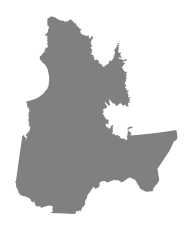

In [2]:
state = ox.geocode_to_gdf('Quebec, CA')
ax = ox.project_gdf(state).plot(fc='gray', ec='none')
_ = ax.axis('off')

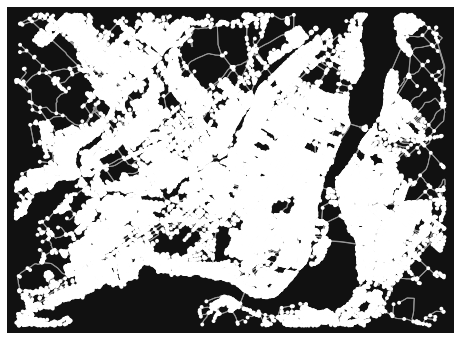

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
# Defining the map boundaries 
north, east, south, west = 45.6923, -73.3736, 45.3874, -73.9730  
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')  
# Plotting the map graph 
ox.plot_graph(G)

In [17]:
def path_finder(solutiondoc):
    stations = pd.read_csv('Stations_2019.csv')
    fp  = open(solutiondoc)
    words= [word.strip() for line in fp.readlines() for word in line.split(',') if word.strip()]
    print(words)

In [18]:
path_finder('tester_path.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'Stations_2019.csv'

In [5]:
origin_point = (45.5173538,-73.58212888)
destination_point = (45.539385081961676,-73.54099988937377)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(G, origin_point) 
destination_node = ox.get_nearest_node(G, destination_point)
# Finding the optimal path 
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length')
print(route)

[29794135, 29784599, 133342201, 208932417, 3577140054, 208932355, 208932395, 208932380, 182070156, 30451683, 209424689, 30451684, 209424712, 209424721, 6896814378, 209424753, 209424759, 209424731, 30451686, 209424746, 32585979, 209424929, 209473668, 209473608, 209473612, 209473664, 438303032, 209481363, 209481366, 209481369, 438304349, 209481435, 209481473, 209473970, 209493244, 209493248, 209493251, 209493254, 209507837, 209508036, 209493262, 209493266, 209493291, 209508004, 218343997, 213760015, 218343991, 218343986, 209507991, 218315741, 218315532, 218315535, 218344052]


In [6]:
route_pd = pd.DataFrame(route)
route_pd.to_csv('path.csv', index = False)

In [7]:
#store long, lat
long = [] 
lat = []  
for i in route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [8]:
route_pd = [lat, long]
route_pd = pd.DataFrame(route_pd)
route_pd = route_pd.T
data = json.loads(pa)
data['features'][0]['geometry'] #Your first point
#route_pd.to_csv('path.csv', index = False)
#route_pd

NameError: name 'pa' is not defined

In [9]:
#store long, lat
""""string = ""{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "vendor":  "A"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [-74.20986, 40.81773, 0],
          [-74.20987, 40.81765, 0],
          [-74.20998, 40.81746, 0]
        ]
      }
    }
  ]
}"""
first_string = "{\"type\": \"FeatureCollection\",\"features\": [{\"type\": \"Feature\",\"properties\": {\"vendor\":  \"A\"},\"geometry\": {\"type\": \"LineString\",\"coordinates\": [ "
coordinates = ""
long = [] 
lat = []  
for i in route: 
    point = G.nodes[i]
    print(point)
    long.append(point['x'])
    lat.append(point['y'])
    long_lat = "[" + str(point['x']) + "," + str(point['y']) + "],\n"
    coordinates += long_lat
final_string = "]}}]}"
string = first_string + coordinates + final_string
print(string)
print(len(route))
file2write=open("pathh",'w')
file2write.write(string)
file2write.close()

{'y': 45.5174755, 'x': -73.5821812, 'street_count': 4}
{'y': 45.5180147, 'x': -73.5816922, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5184878, 'x': -73.5812402, 'street_count': 4}
{'y': 45.5189296, 'x': -73.5808263, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5193716, 'x': -73.5804146, 'street_count': 4}
{'y': 45.5198291, 'x': -73.5799889, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5202855, 'x': -73.5795667, 'street_count': 4}
{'y': 45.5207592, 'x': -73.5791285, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5212077, 'x': -73.5787116, 'street_count': 4}
{'y': 45.521794, 'x': -73.5781665, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5223497, 'x': -73.5776691, 'street_count': 4}
{'y': 45.5227964, 'x': -73.5772587, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5235214, 'x': -73.5765914, 'highway': 'traffic_signals', 'street_count': 4}
{'y': 45.5239843, 'x': -73.5761569, 'street_count': 4}
{'y': 45.5242736, 'x'

In [30]:
"""import pandas as pd
import geojson

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"]))))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

col = ['lat','long']
data = [[-29.9953,-70.5867],
        [-30.1217,-70.4933],
        [-30.0953,-70.5008]]

df = pd.DataFrame(data, columns=col)
data2geojson(df)
print(df)"""

'import pandas as pd\nimport geojson\n\ndef data2geojson(df):\n    features = []\n    insert_features = lambda X: features.append(\n            geojson.Feature(geometry=geojson.Point((X["long"],\n                                                    X["lat"]))))\n    df.apply(insert_features, axis=1)\n    with open(\'map1.geojson\', \'w\', encoding=\'utf8\') as fp:\n        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)\n\ncol = [\'lat\',\'long\']\ndata = [[-29.9953,-70.5867],\n        [-30.1217,-70.4933],\n        [-30.0953,-70.5008]]\n\ndf = pd.DataFrame(data, columns=col)\ndata2geojson(df)\nprint(df)'

In [33]:
def plot_path(lat, long, origin_point, destination_point):
  
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'purple')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [34]:
plot_path(lat, long, origin_point, destination_point)